In [1]:
#Make python screen wider
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
# !pip install tqdm

In [3]:
import numpy as np
import wget
import pandas as pd
import statistics as st
from scipy import stats

from sklearn.model_selection import train_test_split
from sklearn.metrics import mutual_info_score, roc_auc_score
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold

from tqdm.auto import tqdm

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

#increase the width of the line
large_width = 400
np.set_printoptions(linewidth=large_width)

## Homework
## Dataset

In this homework, we will use Credit Card Data from book "Econometric Analysis".

Here's a wget-able [link](https://raw.githubusercontent.com/alexeygrigorev/datasets/master/AER_credit_card_data.csv):

```bash
wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/AER_credit_card_data.csv
```
The goal of this homework is to inspect the output of different evaluation metrics by creating a classification model (target column `card`).

In [4]:
wget.download("https://raw.githubusercontent.com/alexeygrigorev/datasets/master/AER_credit_card_data.csv")

100% [..............................................................................] 73250 / 73250

'AER_credit_card_data.csv'

In [5]:
df_raw=pd.read_csv('AER_credit_card_data.csv')

In [6]:
df = df_raw.copy()

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1319 entries, 0 to 1318
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   card         1319 non-null   object 
 1   reports      1319 non-null   int64  
 2   age          1319 non-null   float64
 3   income       1319 non-null   float64
 4   share        1319 non-null   float64
 5   expenditure  1319 non-null   float64
 6   owner        1319 non-null   object 
 7   selfemp      1319 non-null   object 
 8   dependents   1319 non-null   int64  
 9   months       1319 non-null   int64  
 10  majorcards   1319 non-null   int64  
 11  active       1319 non-null   int64  
dtypes: float64(4), int64(5), object(3)
memory usage: 123.8+ KB


## Preparation

* Create the target variable by mapping `yes` to 1 and `no` to 0. 
* Split the dataset into 3 parts: train/validation/test with 60%/20%/20% distribution. Use `train_test_split` funciton for that with `random_state=1`.

In [8]:
df.card.value_counts()

yes    1023
no      296
Name: card, dtype: int64

In [9]:
df['card'] = (df['card'] == 'yes').astype('int')

In [10]:
df_train_full, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_train_full, test_size=0.25, random_state=1)
len(df), len(df_train), len(df_val), len(df_test)

(1319, 791, 264, 264)

## Question 1

ROC AUC could also be used to evaluate feature importance of numerical variables. 

Let's do that

* For each numerical variable, use it as score and compute AUC with the `card` variable.
* Use the training dataset for that.

If your AUC is < 0.5, invert this variable by putting "-" in front

(e.g. `-df_train['expenditure']`)

AUC can go below 0.5 if the variable is negatively correlated with the target varialble. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

Which numerical variable (among the following 4) has the highest AUC?

- `reports`
- `dependents`
- `active`
- `share`

> ANSWER  
  `share`

In [11]:
#Separate numerical and character variables

num = df_train.select_dtypes(exclude=['object']).columns.tolist()
cat = df_train.select_dtypes(include=['object']).columns.tolist()
num, cat

(['card',
  'reports',
  'age',
  'income',
  'share',
  'expenditure',
  'dependents',
  'months',
  'majorcards',
  'active'],
 ['owner', 'selfemp'])

In [12]:
result = 0
for i in num:
    if i != 'card':
        result = roc_auc_score(df_train['card'], df_train[i])

        print('AUC for variable', i ,'is: ',result)


AUC for variable reports is:  0.28333701393106236
AUC for variable age is:  0.4759979020592945
AUC for variable income is:  0.5908049467233478
AUC for variable share is:  0.989183643423692
AUC for variable expenditure is:  0.991042345276873
AUC for variable dependents is:  0.46722427722262094
AUC for variable months is:  0.470578221903237
AUC for variable majorcards is:  0.5343859842838476
AUC for variable active is:  0.6043173411362006


## Training the model

From now on, use these columns only:

```
["reports", "age", "income", "share", "expenditure", "dependents", "months", "majorcards", "active", "owner", "selfemp"]
```

Apply one-hot-encoding using `DictVectorizer` and train the logistic regression with these parameters:

```
LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
```

In [13]:
# df_train_copy = df_train.copy()
# df_val_copy = df_val.copy()
# df_test_copy = df_test.copy()

In [14]:
final_var = ["reports", "age", "income", "share", "expenditure", "dependents", "months", "majorcards", "active", "owner", "selfemp"]

df_train = df_train_copy.reset_index(drop=True)
df_val = df_val_copy.reset_index(drop=True)
df_test = df_test_copy.reset_index(drop=True)

y_train = df_train['card']
y_val = df_val['card']
y_test = df_test['card']

df_train = df_train[final_var]
df_val = df_val[final_var]
df_test = df_test[final_var]

In [15]:
# there is no need to separate categorical and numerical and after append them in type order [categorical+numerical], values don't change

dv = DictVectorizer(sparse=False)
train_dict = df_train.to_dict(orient='records')
X_train =dv.fit_transform(train_dict)

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, solver='liblinear')

In [16]:
y_train.head()

0    0
1    0
2    1
3    1
4    1
Name: card, dtype: int32

In [17]:
val_dict = df_val.to_dict(orient='records')
X_val = dv.transform(val_dict)

y_pred = model.predict_proba(X_val)[:,1]
card_predicted = (y_pred >= 0.5)

(y_pred == card_predicted).mean()

0.678030303030303

## Question 2

What's the AUC of this model on the validation dataset? (round to 3 digits)

- 0.615
- 0.515
- 0.715
- 0.995

> ANSWER  
  `0.995`

In [18]:
round(roc_auc_score(y_val, y_pred),3)

0.995

## Question 3

Now let's compute precision and recall for our model.

* Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
* For each threshold, compute precision and recall
* Plot them


At which threshold precision and recall curves intersect?

* 0.1
* 0.3
* 0.6
* 0.8

> ANSWER  
  `0.3`

In [19]:
a = np.arange(0, 1.001, 0.01)
a

array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 , 0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21, 0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32, 0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43, 0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54, 0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64,
       0.65, 0.66, 0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77, 0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88, 0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99, 1.  ])

In [20]:

def tpr_fpr_dataframe(y_val, y_pred):

    thresholds = np.arange(0, 1.01, 0.01)

    scores = []
    df_final = []

    for t in thresholds:
        
        actual_positive = 0
        actual_negative = 0
        
        predict_positive = 0
        predict_negative = 0
        
        tp = 0
        tn = 0
        fp = 0
        fn = 0
        
        actual_positive = (y_val == 1)
        actual_negative = (y_val == 0)

        predict_positive = (y_pred >= t)
        predict_negative = (y_pred < t)

        tp = (predict_positive & actual_positive).sum()
        tn = (predict_negative & actual_negative).sum()

        fp = (predict_positive & actual_negative).sum()
        fn = (predict_negative & actual_positive).sum()

        scores.append((t, tp, fp, fn, tn))

        columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
        df_scores = pd.DataFrame(scores, columns=columns)

        df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)
        df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)
        df_scores['precision'] = df_scores.tp / (df_scores.tp + df_scores.fp)
        df_scores['recall'] = df_scores.tp / (df_scores.tp + df_scores.fn)
                    
    return df_scores      

In [21]:
df_scr = tpr_fpr_dataframe(y_val, y_pred)
df_scr

,threshold,tp,fp,fn,tn,tpr,fpr,precision,recall
0,0.00,211,53,0,0,1.000000,1.000000,0.799242,1.000000
1,0.01,211,34,0,19,1.000000,0.641509,0.861224,1.000000
2,0.02,211,31,0,22,1.000000,0.584906,0.871901,1.000000
3,0.03,211,24,0,29,1.000000,0.452830,0.897872,1.000000
4,0.04,211,22,0,31,1.000000,0.415094,0.905579,1.000000
...,...,...,...,...,...,...,...,...,...
96,0.96,204,0,7,53,0.966825,0.000000,1.000000,0.966825
97,0.97,203,0,8,53,0.962085,0.000000,1.000000,0.962085
98,0.98,203,0,8,53,0.962085,0.000000,1.000000,0.962085
99,0.99,202,0,9,53,0.957346,0.000000,1.000000,0.957346


In [22]:
df_scr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101 entries, 0 to 100
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   threshold  101 non-null    float64
 1   tp         101 non-null    int64  
 2   fp         101 non-null    int64  
 3   fn         101 non-null    int64  
 4   tn         101 non-null    int64  
 5   tpr        101 non-null    float64
 6   fpr        101 non-null    float64
 7   precision  101 non-null    float64
 8   recall     101 non-null    float64
dtypes: float64(5), int64(4)
memory usage: 7.2 KB


In [23]:
df_scr.threshold[df_scr['precision']==df_scr['recall']]

24    0.24
25    0.25
26    0.26
27    0.27
28    0.28
29    0.29
Name: threshold, dtype: float64

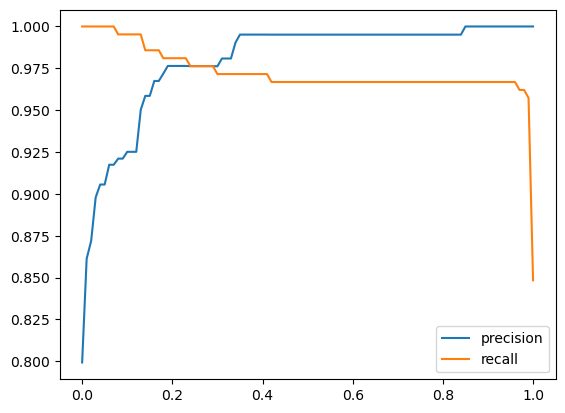

In [24]:
plt.plot(df_scr.threshold, df_scr['precision'], label='precision')
plt.plot(df_scr.threshold, df_scr['recall'], label='recall')
plt.legend()

## Question 4

Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

This is the formula for computing F1:  

F1 = 2 * P * R / (P + R)
 
Where P is precision and R is recall.

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01

At which threshold F1 is maximal?

- 0.1
- 0.4
- 0.6
- 0.7

> ANSWER  
  `0.4`

In [25]:
df_scr['f1'] = (2 * df_scr.precision * df_scr.recall) / (df_scr.precision + df_scr.recall)

In [26]:
print(df_scr[df_scr['f1'].max() == df_scr['f1']])

    threshold   tp  fp  fn  tn       tpr       fpr  precision    recall  \
35       0.35  205   1   6  52  0.971564  0.018868   0.995146  0.971564   
36       0.36  205   1   6  52  0.971564  0.018868   0.995146  0.971564   
37       0.37  205   1   6  52  0.971564  0.018868   0.995146  0.971564   
38       0.38  205   1   6  52  0.971564  0.018868   0.995146  0.971564   
39       0.39  205   1   6  52  0.971564  0.018868   0.995146  0.971564   
40       0.40  205   1   6  52  0.971564  0.018868   0.995146  0.971564   
41       0.41  205   1   6  52  0.971564  0.018868   0.995146  0.971564   

          f1  
35  0.983213  
36  0.983213  
37  0.983213  
38  0.983213  
39  0.983213  
40  0.983213  
41  0.983213  


## Question 5

Use the `KFold` class from Scikit-Learn to evaluate our model on 5 different folds:

```
KFold(n_splits=5, shuffle=True, random_state=1)
```

* Iterate over different folds of `df_full_train`
* Split the data into train and validation
* Train the model on train with these parameters: `LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)`
* Use AUC to evaluate the model on validation


How large is standard devidation of the AUC scores across different folds?

- 0.003
- 0.014
- 0.09
- 0.24
> ANSWER  
  `0.003`

In [27]:
df_train_full.head()

,card,reports,age,income,share,expenditure,owner,selfemp,dependents,months,majorcards,active
710,0,1,36.83333,3.0000,0.000400,0.000000,yes,no,1,12,1,16
1258,1,0,35.58333,3.5606,0.109084,323.587500,no,no,0,12,1,0
435,1,0,25.66667,2.0000,0.004900,7.416667,no,no,0,26,1,13
987,0,0,25.58333,1.7500,0.000686,0.000000,no,no,0,108,0,0
1286,1,1,48.66667,6.0000,0.177017,885.085800,yes,no,3,114,1,19


In [28]:
df_train_full2 = df_train_full.copy()

In [29]:
def train_model(df_train, y_train, C=1.0):
    dicts = df_train.to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(C=C, max_iter=1000)
    model.fit(X_train, y_train)
    
    return dv, model

In [30]:
def predict_model(df, dv, model):
    dicts = df.to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [31]:
    final_var2 = ["reports", "age", "income", "share", "expenditure", "dependents", "months", "majorcards", "active", "owner", "selfemp"]
    kfold = KFold(n_splits=5, shuffle=True, random_state=1)
    scores2 = []

    for train_idx, val_idx in kfold.split(df_train_full2):
        
        df_train2 = df_train_full2.iloc[train_idx]
        df_val2 = df_train_full2.iloc[val_idx]

        y_train2 = df_train2['card'].values
        y_val2 = df_val2['card'].values
        
        df_train2 = df_train2[final_var2]
        df_val2 = df_val2[final_var2]
        
        dv2, model2 = train_model(df_train2, y_train2,C=1.0)
        y_pred2 = predict_model(df_val2, dv2, model2)

        auc2 = roc_auc_score(y_val2, y_pred2)
        scores2.append(auc2)

    scores2

[0.9943244739756367,
 0.9944852941176471,
 0.9938076416337287,
 0.9997405293201868,
 1.0]

In [32]:
round(np.std(scores2),3)

0.003

## Question 6

Now let's use 5-Fold cross-validation to find the best parameter C

* Iterate over the following C values: `[0.01, 0.1, 1, 10]`
* Initialize `KFold` with the same parameters as previously
* Use these parametes for the model: `LogisticRegression(solver='liblinear', C=C, max_iter=1000)`
* Compute the mean score as well as the std (round the mean and std to 3 decimal digits)


Which C leads to the best mean score?

- 0.01
- 0.1
- 1
- 10

If you have ties, select the score with the lowest std. If you still have ties, select the smallest C

> ANSWER  
  `After rounding there is a tie for mean and std, then the smallest C is 0.1`

In [33]:
df_train_full2 = df_train_full.copy()

In [35]:
final_var2 = ["reports", "age", "income", "share", "expenditure", "dependents", "months", "majorcards", "active", "owner", "selfemp"]
 

for C in tqdm([0.01, 0.1, 1, 10]):
    
    kfold = KFold(n_splits=5, shuffle=True, random_state=1)

    scores2 = []

    for train_idx, val_idx in kfold.split(df_train_full2):
        
        df_train2 = df_train_full2.iloc[train_idx]
        df_val2 = df_train_full2.iloc[val_idx]

        y_train2 = df_train2['card'].values
        y_val2 = df_val2['card'].values
        
        df_train2 = df_train2[final_var2]
        df_val2 = df_val2[final_var2]
        
        dv2, model2 = train_model(df_train2, y_train2, C=C)
        y_pred2 = predict_model(df_val2, dv2, model2)

        auc2 = roc_auc_score(y_val2, y_pred2)
        scores2.append(auc2)
        
    print(C, '\t', 'mean rounded=', round(np.mean(scores2),3), '\t', 'std rounded=', round(np.std(scores2),3))

  0%|          | 0/4 [00:00<?, ?it/s]

0.01 	 mean rounded= 0.995 	 std rounded= 0.004
0.1 	 mean rounded= 0.997 	 std rounded= 0.003
1 	 mean rounded= 0.996 	 std rounded= 0.003
10 	 mean rounded= 0.997 	 std rounded= 0.003
